# 1.6a: Cluster Definition

This notebook defines cluster membership using a two-stage filter with **iterative refinement**:

1. **Spatial bounds** - Lat/lon rectangle from telescope coordinates
2. **Indistinguishability** - Dot product equality in bfloat16
3. **Iterative refinement** - Recompute centroid using only indistinguishable tokens, repeat until stable

## The Strategy

We start with a spatial region (the apparent cluster visible in the telescope view), compute its centroid, find indistinguishable tokens, then **refine the centroid** using only those indistinguishable tokens. This converges to the true cluster core regardless of spatial bounds.

**Why iterative refinement?**

The mean (centroid) is not robust to outliers. If the spatial bounds include peripheral tokens far from the core cluster, they pull the centroid away from the dense core. By iteratively refining, we converge to the centroid of the actual cluster.

**Cluster = tokens where:**
- IN the initial spatial bounds
- AND `t @ centroid_refined = ||centroid_refined||²` in bfloat16
- Where centroid_refined is computed iteratively from indistinguishable tokens only

## Parameters

In [164]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# PCA basis selection (from 1.3c)
NORTH_PC = 2      # North pole (+90° latitude)
MERIDIAN_PC = 1   # Prime meridian (0° longitude)
EQUINOX_PC = 3    # Equinox (+90° longitude)

# Telescope pointing (copy these from 1.3c after setting them there)
CENTER_LAT = -7.289       # Latitude of center (degrees)
CENTER_LON = 6.940        # Longitude of center (degrees)
ANGULAR_DIAMETER = 3.000  # Field of view (degrees)

# Iterative refinement
MAX_ITERATIONS = 10       # Maximum refinement iterations
CONVERGENCE_TOL = 1e-3    # Convergence threshold (centroid shift)

## Imports

In [165]:
import torch
import matplotlib.pyplot as plt
from safetensors.torch import load_file, save_file
from pathlib import Path

## Device Detection

In [166]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load W

In [167]:
# Load W in bfloat16
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"Loaded W from {W_path}")
print(f"  Shape: {W_bf16.shape}")
print(f"  Dtype: {W_bf16.dtype}")

# Also keep float32 version for PCA/spherical coords
W_f32 = W_bf16.to(torch.float32)

N, d = W_bf16.shape
print(f"\nToken space: {N:,} tokens in {d:,} dimensions")

Loaded W from ../tensors/Qwen3-4B-Instruct-2507/W.safetensors
  Shape: torch.Size([151936, 2560])
  Dtype: torch.bfloat16

Token space: 151,936 tokens in 2,560 dimensions


## Compute PCA

In [168]:
print("Computing PCA...\n")

# Center the data
W_centered = W_f32 - W_f32.mean(dim=0)

# Compute covariance matrix
cov = (W_centered.T @ W_centered) / N

# Eigendecomposition
eigenvalues, eigenvectors = torch.linalg.eigh(cov)

# Sort by descending eigenvalue
idx = torch.argsort(eigenvalues, descending=True)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("✓ PCA computed")

Computing PCA...

✓ PCA computed


## Define Spherical Basis

In [169]:
def get_pc_vector(pcs, index):
    """Get PC vector by index (1-indexed), with sign flip for negative indices."""
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector


# Extract basis vectors
north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

print("Spherical coordinate basis:")
print(f"  North (+Z, north pole):    PC{NORTH_PC}")
print(f"  Meridian (+X, 0° lon):     PC{MERIDIAN_PC}")
print(f"  Equinox (+Y, 90° lon):     PC{EQUINOX_PC}")

Spherical coordinate basis:
  North (+Z, north pole):    PC2
  Meridian (+X, 0° lon):     PC1
  Equinox (+Y, 90° lon):     PC3


## Project to Spherical Coordinates

In [170]:
print("\nProjecting to spherical coordinates...\n")

# Project onto basis vectors
x = W_f32 @ meridian
y = W_f32 @ equinox
z = W_f32 @ north

# Compute radius
r = torch.sqrt(x**2 + y**2 + z**2)

# Spherical coordinates
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)

lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print("✓ Spherical coordinates computed")


Projecting to spherical coordinates...

✓ Spherical coordinates computed


## Initial Spatial Filter

In [171]:
print(f"\nApplying initial spatial filter...")
print(f"  Center: ({CENTER_LAT:.3f}°, {CENTER_LON:.3f}°)")
print(f"  Angular diameter: {ANGULAR_DIAMETER:.3f}°")
print()

# Define region bounds
half_width = ANGULAR_DIAMETER / 2
lat_min = CENTER_LAT - half_width
lat_max = CENTER_LAT + half_width
lon_min = CENTER_LON - half_width
lon_max = CENTER_LON + half_width

print(f"  Latitude range: [{lat_min:.3f}°, {lat_max:.3f}°]")
print(f"  Longitude range: [{lon_min:.3f}°, {lon_max:.3f}°]")
print()

# Filter tokens
spatial_mask = (
    (lat_deg >= lat_min) & (lat_deg <= lat_max) &
    (lon_deg >= lon_min) & (lon_deg <= lon_max)
)

n_spatial = spatial_mask.sum().item()

print(f"✓ Initial spatial region: {n_spatial:,} tokens")
print(f"  ({n_spatial/N*100:.2f}% of vocabulary)")


Applying initial spatial filter...
  Center: (-7.289°, 6.940°)
  Angular diameter: 3.000°

  Latitude range: [-8.789°, -5.789°]
  Longitude range: [5.440°, 8.440°]

✓ Initial spatial region: 2,956 tokens
  (1.95% of vocabulary)


## Iterative Refinement

In [172]:
print(f"\nStarting iterative refinement...")
print(f"  Max iterations: {MAX_ITERATIONS}")
print(f"  Convergence tolerance: {CONVERGENCE_TOL}")
print()

# Move W to device
W_bf16_device = W_bf16.to(device)

# Initialize with spatial region tokens
current_mask = spatial_mask.clone()
h = W_bf16[current_mask].mean(dim=0)  # Initial centroid

iteration_history = []

for iteration in range(MAX_ITERATIONS):
    # Move centroid to device
    h_device = h.to(device)
    
    # Compute all dot products in bfloat16
    with torch.no_grad():
        dots = W_bf16_device @ h_device
    
    # Move to CPU
    dots_cpu = dots.cpu()
    
    # Target dot product
    h_dot_h = (h @ h).item()
    
    # Find indistinguishable tokens (within spatial region)
    indist_global = (dots_cpu == h_dot_h)
    new_mask = spatial_mask & indist_global
    
    n_new = new_mask.sum().item()
    n_indist_total = indist_global.sum().item()
    
    # Recompute centroid from indistinguishable tokens
    h_new = W_bf16[new_mask].mean(dim=0)
    
    # Check convergence (how much did centroid move?)
    centroid_shift = (h_new - h).norm().item()
    
    # Record iteration
    iteration_history.append({
        'iteration': iteration,
        'n_cluster': n_new,
        'n_indist_total': n_indist_total,
        'centroid_shift': centroid_shift,
        'h_dot_h': h_dot_h,
    })
    
    print(f"Iteration {iteration}:")
    print(f"  Cluster size: {n_new:,}")
    print(f"  Indistinguishable (total): {n_indist_total:,}")
    print(f"  Centroid shift: {centroid_shift:.8f}")
    
    # Check convergence
    if centroid_shift < CONVERGENCE_TOL:
        print(f"\n✓ Converged after {iteration + 1} iterations")
        break
    
    # Update for next iteration
    current_mask = new_mask
    h = h_new
else:
    print(f"\n⚠ Did not converge within {MAX_ITERATIONS} iterations")

# Final cluster
cluster_mask = new_mask
n_cluster = cluster_mask.sum().item()
n_filtered_out = n_spatial - n_cluster


Starting iterative refinement...
  Max iterations: 10
  Convergence tolerance: 0.001

Iteration 0:
  Cluster size: 58
  Indistinguishable (total): 1,262
  Centroid shift: 0.03710938
Iteration 1:
  Cluster size: 2,260
  Indistinguishable (total): 3,346
  Centroid shift: 0.04101562
Iteration 2:
  Cluster size: 2,252
  Indistinguishable (total): 3,256
  Centroid shift: 0.00150299
Iteration 3:
  Cluster size: 2,248
  Indistinguishable (total): 3,251
  Centroid shift: 0.00091553

✓ Converged after 4 iterations


## Results Summary

In [173]:
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print()
print(f"Initial spatial region: {n_spatial:,} tokens")
print(f"Final cluster (after refinement): {n_cluster:,} tokens")
print(f"Filtered out: {n_filtered_out:,} tokens")
print()
print(f"Retention rate: {n_cluster/n_spatial*100:.2f}%")
print()
print(f"Indistinguishable tokens (total vocab): {n_indist_total:,}")
if n_indist_total > n_cluster:
    n_outside = n_indist_total - n_cluster
    print(f"  → {n_outside:,} indistinguishable tokens lie OUTSIDE spatial bounds")
    print(f"     (distant tokens on the same hyperplane)")
print()
print("="*60)


FINAL RESULTS

Initial spatial region: 2,956 tokens
Final cluster (after refinement): 2,248 tokens
Filtered out: 708 tokens

Retention rate: 76.05%

Indistinguishable tokens (total vocab): 3,251
  → 1,003 indistinguishable tokens lie OUTSIDE spatial bounds
     (distant tokens on the same hyperplane)



## Save Results

In [174]:
print("\nSaving results...\n")

# Get cluster token IDs
cluster_token_ids = cluster_mask.nonzero(as_tuple=True)[0]

# Convert masks to uint8 for storage
cluster_mask_uint8 = cluster_mask.to(torch.uint8)
spatial_mask_uint8 = spatial_mask.to(torch.uint8)

# Save to safetensors
output_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_mask.safetensors")
output_path.parent.mkdir(parents=True, exist_ok=True)

save_file({
    "cluster_mask": cluster_mask_uint8,
    "cluster_token_ids": cluster_token_ids.to(torch.int32),
    "spatial_mask": spatial_mask_uint8,
    "centroid": h,
    "n_cluster": torch.tensor([n_cluster], dtype=torch.int32),
    "n_spatial": torch.tensor([n_spatial], dtype=torch.int32),
    "n_filtered": torch.tensor([n_filtered_out], dtype=torch.int32),
    "n_iterations": torch.tensor([iteration + 1], dtype=torch.int32),
    "center_lat": torch.tensor([CENTER_LAT], dtype=torch.float32),
    "center_lon": torch.tensor([CENTER_LON], dtype=torch.float32),
    "angular_diameter": torch.tensor([ANGULAR_DIAMETER], dtype=torch.float32),
}, str(output_path))

print(f"✓ Saved to {output_path}")
print()
print("Saved tensors:")
print(f"  cluster_mask: ({N},) - final cluster (spatial AND indist, refined)")
print(f"  cluster_token_ids: ({n_cluster},) - token IDs")
print(f"  spatial_mask: ({N},) - initial spatial region")
print(f"  centroid: ({d},) - refined centroid (h) in bfloat16")
print(f"  n_cluster: scalar - {n_cluster:,}")
print(f"  n_spatial: scalar - {n_spatial:,}")
print(f"  n_filtered: scalar - {n_filtered_out:,}")
print(f"  n_iterations: scalar - {iteration + 1}")
print(f"  center_lat, center_lon, angular_diameter: telescope params")


Saving results...

✓ Saved to ../tensors/Qwen3-4B-Instruct-2507/1.6a_cluster_mask.safetensors

Saved tensors:
  cluster_mask: (151936,) - final cluster (spatial AND indist, refined)
  cluster_token_ids: (2248,) - token IDs
  spatial_mask: (151936,) - initial spatial region
  centroid: (2560,) - refined centroid (h) in bfloat16
  n_cluster: scalar - 2,248
  n_spatial: scalar - 2,956
  n_filtered: scalar - 708
  n_iterations: scalar - 4
  center_lat, center_lon, angular_diameter: telescope params


## Convergence Plot

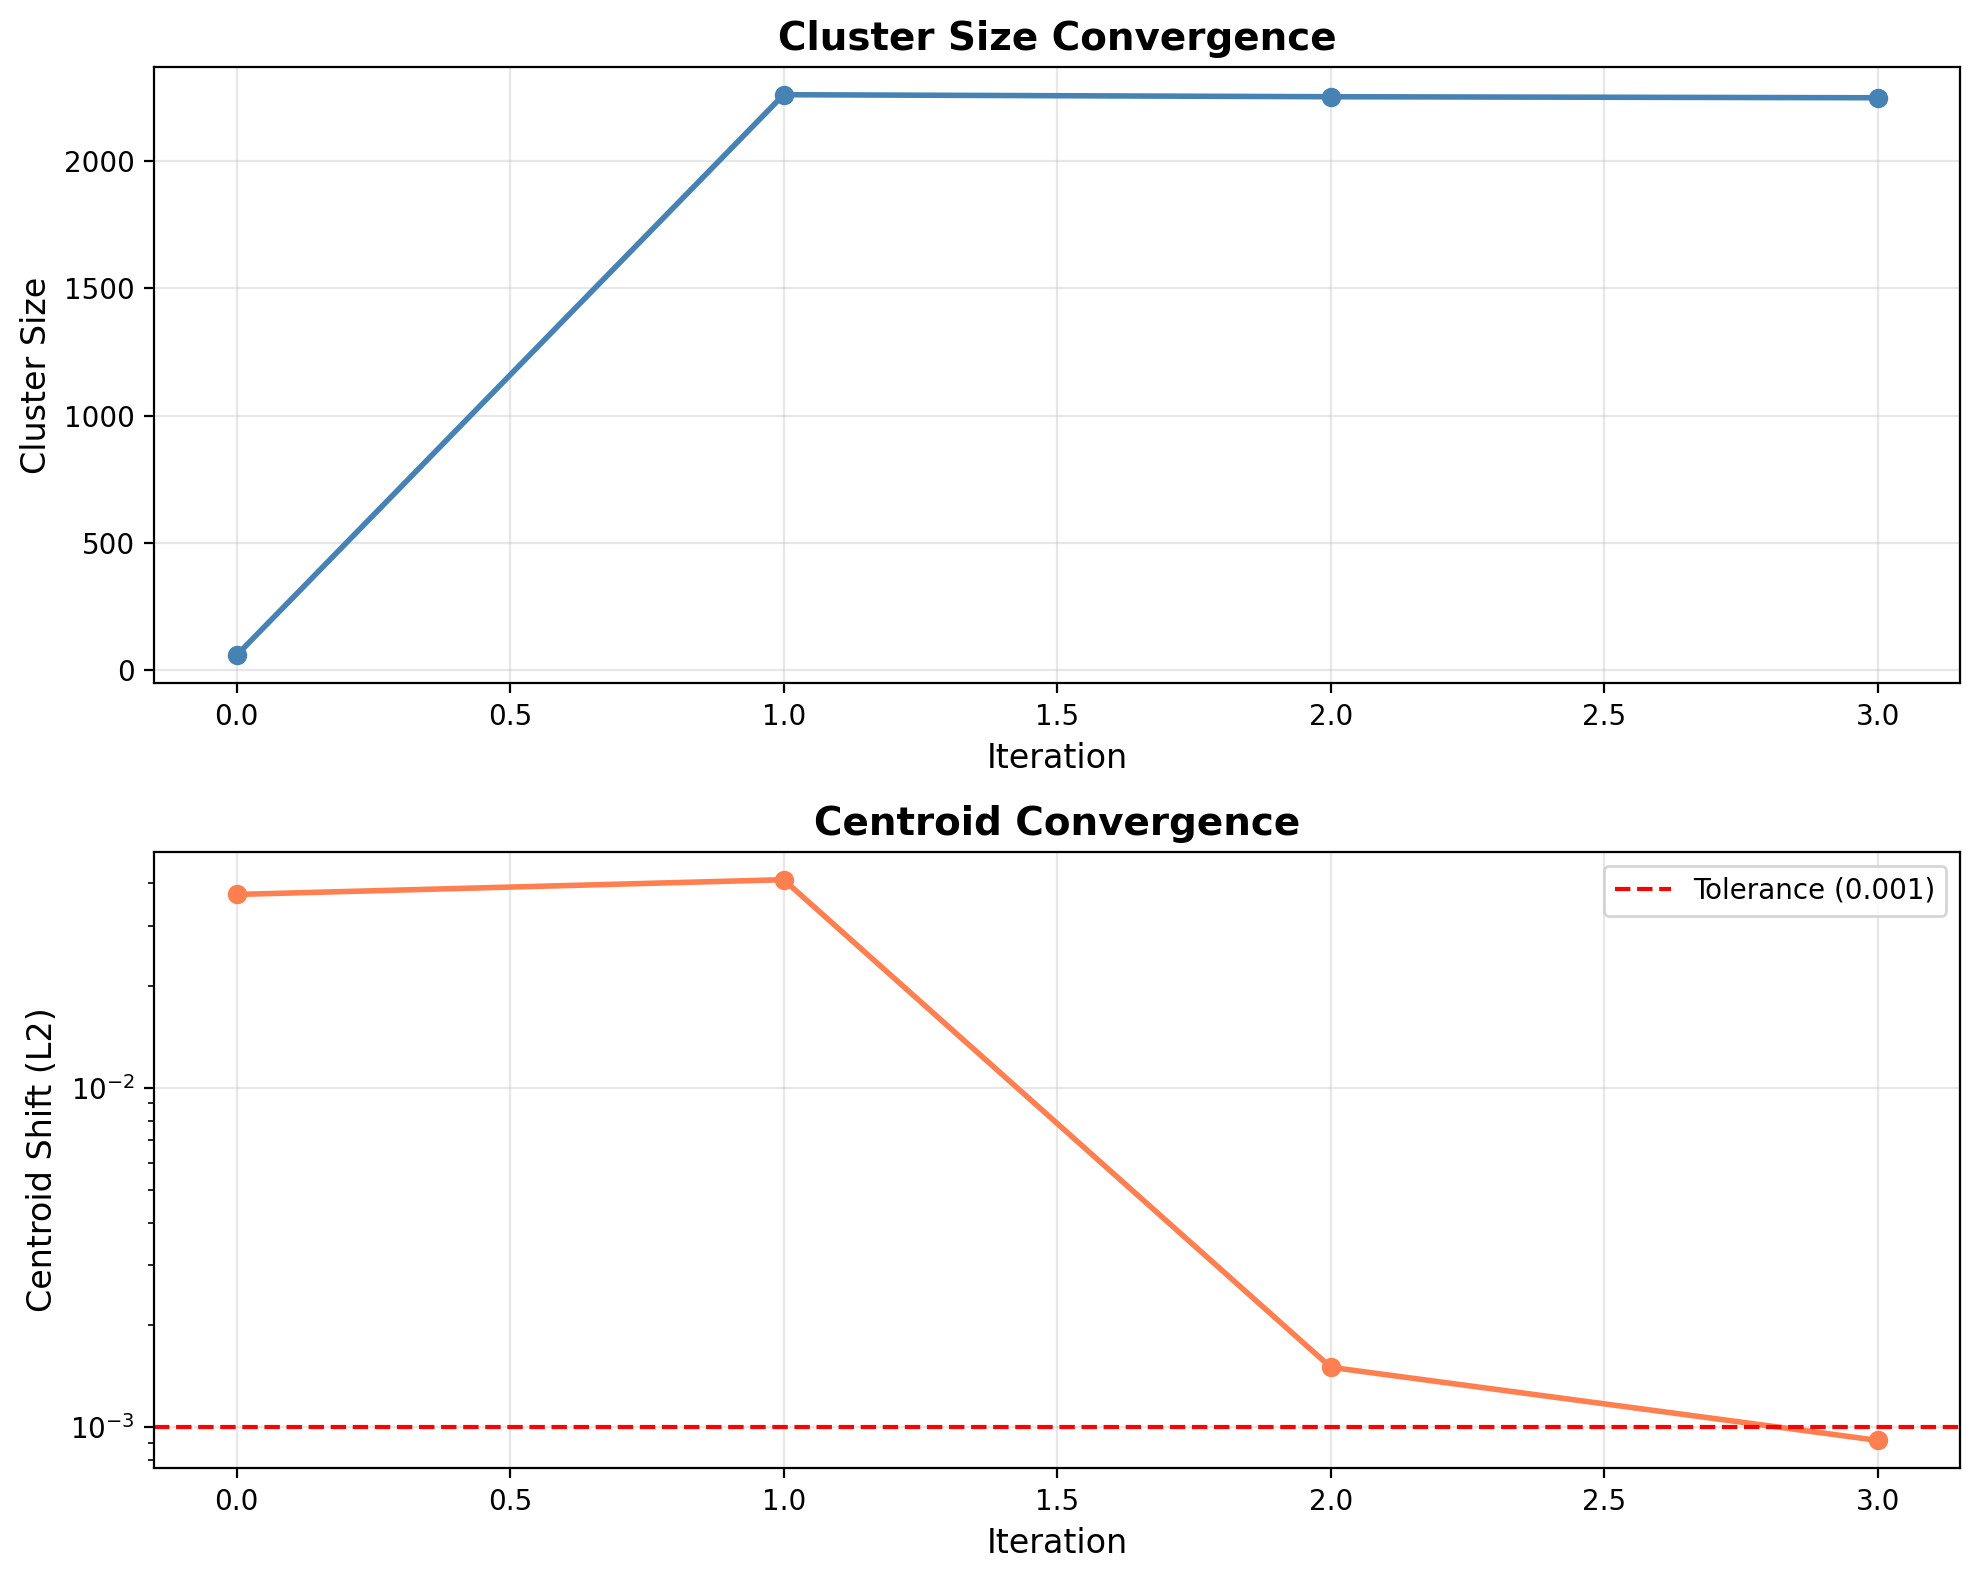


✓ Convergence plot complete


In [175]:
if len(iteration_history) > 1:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), dpi=200)
    
    iterations = [h['iteration'] for h in iteration_history]
    cluster_sizes = [h['n_cluster'] for h in iteration_history]
    centroid_shifts = [h['centroid_shift'] for h in iteration_history]
    
    # Cluster size over iterations
    ax1.plot(iterations, cluster_sizes, 'o-', color='steelblue', linewidth=2, markersize=6)
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Cluster Size', fontsize=12)
    ax1.set_title('Cluster Size Convergence', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Centroid shift over iterations
    ax2.plot(iterations, centroid_shifts, 'o-', color='coral', linewidth=2, markersize=6)
    ax2.axhline(CONVERGENCE_TOL, color='red', linestyle='--', label=f'Tolerance ({CONVERGENCE_TOL})')
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Centroid Shift (L2)', fontsize=12)
    ax2.set_title('Centroid Convergence', fontsize=14, fontweight='bold')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Convergence plot complete")
else:
    print("\nConverged in 1 iteration - no plot needed")